In [3]:
import torch
import math
import pandas as pd
import numpy as np
from scipy.stats import truncexpon, truncnorm, nbinom
import matplotlib.pyplot as plt

In [12]:
dtype = torch.float
device = torch.device("cpu")
learning_rate = 1e-20

In [13]:
#---------------Model---------------
data = pd.read_csv('data/covid19model.csv')

 R0:3.542384147644043, grad: 22843908.0, alpha: 0.010001198388636112 grad: 13376806912.0, sigma: 0.04642344266176224 grad 0.0
 R0:3.542384147644043, grad: 15425256.0, alpha: 0.010001198388636112 grad: 21113001984.0, sigma: 0.04642344266176224 grad 0.0
 R0:3.542384147644043, grad: 17198344.0, alpha: 0.010001198388636112 grad: 15867659264.0, sigma: 0.04642344266176224 grad 0.0


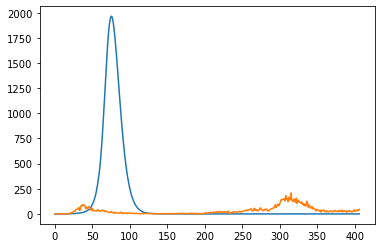

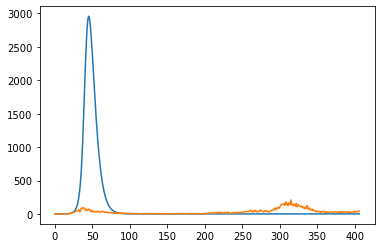

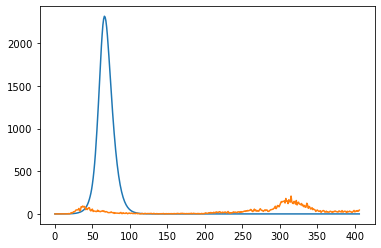

In [14]:
cero = torch.tensor(0, requires_grad=False, device=device, dtype=dtype)
num_impute = 6
observed_daily_hospit = torch.tensor(data.hospit, requires_grad=False, device=device, dtype=dtype)
pi = torch.tensor(data.delay_distr, requires_grad=False, device=device, dtype=dtype)
serial_interval = torch.tensor(data.serial_interval, requires_grad=False, device=device, dtype=dtype)
population = torch.tensor(5793636, requires_grad=False, device=device, dtype=dtype)


num_observations = len(observed_daily_hospit)
tau = np.random.exponential(1 / 0.03)
#tau_t = torch.tensor(np.random.exponential(1 / 0.03), requires_grad=True, device=device, dtype=dtype)
# b=(upper-lower)/scale, loc=lower, scale=scale
y = torch.tensor(truncexpon.rvs(b=(1000 - 0) / tau, loc=0, scale=tau), requires_grad=False, device=device, dtype=dtype)  # number of initial newly_infected (seed)
# For trunc ((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
#phi = torch.tensor(truncnorm.rvs((0 - 0) / 5, (np.inf - 0) / 5, loc=0, scale=5), requires_grad=True, device=device, dtype=dtype)  # dispersion (shape) parameter for observations
R0 = torch.tensor(truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8), requires_grad=True, device=device, dtype=dtype)  # initial reproduction number
alpha = torch.tensor(truncnorm.rvs((0 - 1/100) / 1/100, (5/100 - 1/100) / 1/100, loc=1/100, scale=1/100), requires_grad=True, device=device, dtype=dtype)  # probability to get hospitalized
sigma = torch.tensor(truncnorm.rvs((0 - 0.05) / 0.03, (0.15 - 0.05) / 0.03, loc=0.05, scale=0.03), requires_grad=True, device=device, dtype=dtype)  # standart deviation of random walk step


for k in range(3):

    # Initizalize tensors
    newly_infected = torch.zeros(num_observations)  # number of newly infected
    effectively_infectious = torch.zeros(num_observations)  # effective number of infectious individuals
    expected_daily_hospit = torch.zeros(num_observations)  # expected number of daily hospitalizations
    cumulative_infected = torch.zeros(num_observations)  # cumulative number of infected
    eta_t = torch.zeros(num_observations)  # transformed reproduction number
    epsilon_t = torch.zeros(num_observations)  # random walk
    St = torch.zeros(num_observations)  # fraction of susceptible population
    newly_infected[0:num_impute] = y.clone()
    cumulative_infected[0] = 0.
    cumulative_infected[1:num_impute] = torch.cumsum(newly_infected[0:num_impute - 1].clone(), dim=0)
    St[0:num_impute] = torch.tensor([torch.maximum(population.clone() - x, cero) / population for x in cumulative_infected[0:num_impute].clone()])

    # calculate Rt: the basic reproduction number
    beta_0 = torch.log(R0)
    epsilon_t[0] = torch.normal(cero, sigma)

    for t in range(1, num_observations):
        epsilon_t[t] = torch.normal(epsilon_t[t - 1].clone(), sigma)
        eta_t[t] = beta_0.clone() + epsilon_t[t].clone()  # + RNN[X_t, t]

    Rt = torch.exp(eta_t.clone())
    # calculate infections
    for t in range(num_impute, num_observations):
        # Update cumulative newly_infected
        cumulative_infected[t] = cumulative_infected[t - 1].clone() + newly_infected[t - 1].clone()
        # Adjusts for portion of pop that are susceptible
        St[t] = torch.maximum(population.clone() - cumulative_infected[t].clone(), cero) / population.clone()
        # effective number of infectous individuals
        for i in range(0, t - 1):
            effectively_infectious[t] += newly_infected[i].clone() * serial_interval[t - i].clone()

       # [newly_infected[i] * serial_interval[t - i] for i in range(0, t - 1)]
       # effectively_infectious[t] = torch.sum([newly_infected[i] * serial_interval[t - i] for i in range(0, t - 1)])

        # number of new infections (unobserved)
        newly_infected[t] = St[t].clone() * Rt[t].clone() * effectively_infectious[t].clone()
    # calculate expected number of hospitalizations
    expected_daily_hospit[0] = (1e-15) * newly_infected[0].clone()
    for t in range(1, num_observations):
        for i in range(0, t - 1):
            expected_daily_hospit[t] += newly_infected[i].clone() * pi[t - i].clone()
        expected_daily_hospit[t] = alpha.clone() * expected_daily_hospit[t].clone()

    loss = (expected_daily_hospit - observed_daily_hospit).pow(2).sum()
    loss.backward()


    with torch.no_grad():
        #tau_t -= learning_rate * tau_t.grad
        #phi -= learning_rate * phi.grad

        R0 -= learning_rate * R0.grad
        alpha -= learning_rate * alpha.grad
        sigma -= learning_rate * sigma.grad
        print(f' R0:{R0}, grad: {R0.grad}, alpha: {alpha} grad: {alpha.grad}, sigma: {sigma} grad {sigma.grad}' )
        # Manually zero the gradients after updating weights
        #tau_t.grad = None
        #phi.grad = None
        R0.grad = None
        alpha.grad = None
        sigma.grad = None


    plt.plot(expected_daily_hospit.detach().numpy())
    plt.plot(observed_daily_hospit.detach().numpy())
    plt.show()